### Database Driven Machine Learning Model
Video game Logistic Regression - resample - EU from NA and JP

This notebook uses a heroku database driven ML model to predict EU Sales based on Platform, Genre, NA_Sales, and JP_Sales. The notebook sets the threshold for EU_Sales to some value independent of the median value of EU_Sales and investigates oversampling, undersampling, and combination sampling to balance the yes/no values for EU_Sales.

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import psycopg2
from config import config

%matplotlib inline
import matplotlib.pyplot as plt

### Read in data and remove unnecessary columns

In [2]:
#Define Function to Retrieve Data From Heroku
def get_Data():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
         # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        sql = "SELECT gm.rank, gm.na_sales, gm.eu_sales, gm.jp_sales, " \
                "p.platform, " \
                "g.genre " \
                "FROM game gm " \
                "INNER JOIN platform p " \
                "ON gm.platform_id=p.id " \
                "INNER JOIN genre g " \
                "ON gm.genre_id=g.id"
            
        #print('PostgreSQL database query: ' sql)
        query = pd.read_sql_query(sql, conn)
        
        df = pd.DataFrame(query)
        return df
    # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [3]:
#Query Heroku For Data and create DataFrame
df = get_Data()
df

Connecting to the PostgreSQL database...
Database connection closed.


,rank,na_sales,eu_sales,jp_sales,platform,genre
0,6086,0.00,0.00,0.29,PS3,Sports
1,6819,0.06,0.13,0.00,PS2,Action
2,8108,0.05,0.10,0.00,PS2,Racing
3,7038,0.13,0.09,0.00,GBA,Shooter
4,14545,0.02,0.01,0.00,3DS,Adventure
...,...,...,...,...,...,...
9795,3059,0.26,0.01,0.13,PS3,Puzzle
9796,1469,0.79,0.42,0.00,Wii,Action
9797,4063,0.00,0.47,0.00,DS,Action
9798,3406,0.24,0.28,0.00,Wii,Fighting


In [4]:
# Reorder and Rename Columns for Machine Learning Model
vg_sales_df = df.reindex(columns= ['rank', 'platform', 'genre', 'na_sales', 'eu_sales', 'jp_sales'])
#vg_sales_df.set_index("Rank", inplace=True)
vg_sales_df.drop(['rank'], axis=1, inplace=True)
vg_sales_df.columns = ['Platform', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales']
vg_sales_df

,Platform,Genre,NA_Sales,EU_Sales,JP_Sales
0,PS3,Sports,0.00,0.00,0.29
1,PS2,Action,0.06,0.13,0.00
2,PS2,Racing,0.05,0.10,0.00
3,GBA,Shooter,0.13,0.09,0.00
4,3DS,Adventure,0.02,0.01,0.00
...,...,...,...,...,...
9795,PS3,Puzzle,0.26,0.01,0.13
9796,Wii,Action,0.79,0.42,0.00
9797,DS,Action,0.00,0.47,0.00
9798,Wii,Fighting,0.24,0.28,0.00


In [5]:
print(vg_sales_df.dtypes)

Platform     object
Genre        object
NA_Sales    float64
EU_Sales    float64
JP_Sales    float64
dtype: object


In [6]:
# Get unique Platform values
vg_sales_df["Platform"].unique()

array(['PS3', 'PS2', 'GBA', '3DS', 'PS', 'PSP', 'DS', 'Wii', 'PC', 'X360',
       'GC', 'PSV', 'N64', 'XB', 'GB', 'NES', 'XOne', 'SAT', 'WiiU',
       'SNES', '2600', 'PS4', 'GEN', 'DC', '3DO', 'SCD', 'WS', 'PCFX',
       'NG'], dtype=object)

In [7]:
# Make sure there are no null values
vg_sales_df["Platform"].isnull().sum()

0

In [8]:
# Get unique Genre values
vg_sales_df["Genre"].unique()

array(['Sports', 'Action', 'Racing', 'Shooter', 'Adventure',
       'Role-Playing', 'Fighting', 'Simulation', 'Misc', 'Platform',
       'Puzzle', 'Strategy'], dtype=object)

In [9]:
# Make sure sales columns do not have null values
print(f"NA_Sales has {vg_sales_df['NA_Sales'].isnull().sum()} null values.")
print(f"EU_Sales has {vg_sales_df['EU_Sales'].isnull().sum()} null values.")
print(f"JP_Sales has {vg_sales_df['JP_Sales'].isnull().sum()} null values.")

NA_Sales has 0 null values.
EU_Sales has 0 null values.
JP_Sales has 0 null values.


### Histogram of Sales Data

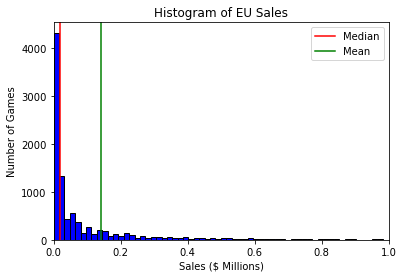

The median sales for EU is $0.02 Million


In [10]:
# Create Histogram to view NA Sales distribution
plt.hist(vg_sales_df['EU_Sales'], color = 'blue', edgecolor = 'black',
         bins = 800)
plt.title('Histogram of EU Sales')
plt.xlabel('Sales ($ Millions)')
plt.ylabel('Number of Games')
plt.xlim(left=0, right=1)
plt.axvline(vg_sales_df['EU_Sales'].median(),label="Median",color='red')
plt.axvline(vg_sales_df['EU_Sales'].mean(),label="Mean",color='green')
plt.legend()
plt.show()

print(f"The median sales for EU is ${round(vg_sales_df['EU_Sales'].median(),3)} Million")

### Categorize Other_Sales Column

In [11]:
# Copy vg_sales_df
categorize_eu_sales = vg_sales_df.filter(["EU_Sales"], axis=1)
categorize_eu_sales

,EU_Sales
0,0.00
1,0.13
2,0.10
3,0.09
4,0.01
...,...
9795,0.01
9796,0.42
9797,0.47
9798,0.28


## Calculate statistics for EU Sales

In [12]:
eu_sales_stats = vg_sales_df.filter(["EU_Sales"], axis=1)
# eu_sales_stats.quantile(q=0.75)

### Set Threshold Sales Number

In [13]:
# Set threshold sales number
# na_sales_threshold = round(sales_data_nrm['NA_Sales'].median(),3)
# eu_sales_threshold = 0.2
# eu_sales_threshold = eu_sales_stats.quantile(q=0.75)[0]
eu_sales_threshold = vg_sales_df.filter(["EU_Sales"], axis=1).quantile(q=0.75)[0]
eu_sales_threshold

0.11

In [14]:
eu_sales_stats.describe()

,EU_Sales
count,9800.000000
mean,0.142509
std,0.433554
min,0.000000
25%,0.000000
50%,0.020000
75%,0.110000
max,12.880000


In [15]:
# Reassign NA_sales value
for index,row in categorize_eu_sales.iterrows():
    
    # NA Sales
    if row.EU_Sales > eu_sales_threshold:
        categorize_eu_sales.loc[index] = 1
    else:
        categorize_eu_sales.loc[index] = 0

eu_sales_col_name = "EU_Sales_gt_" + str(eu_sales_threshold)
categorize_eu_sales.\
    rename(columns={"EU_Sales": eu_sales_col_name}, inplace=True)

categorize_eu_sales.head()

,EU_Sales_gt_0.11
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


### Separate Sales Data for NA and JP

In [16]:
sales_data = vg_sales_df.filter(["NA_Sales", "JP_Sales"], axis=1)
sales_data.head()

,NA_Sales,JP_Sales
0,0.00,0.29
1,0.06,0.00
2,0.05,0.00
3,0.13,0.00
4,0.02,0.00


In [17]:
# Create platform df
platform_df = vg_sales_df.filter(["Platform"], axis=1)
platform_df.head()

,Platform
0,PS3
1,PS2
2,PS2
3,GBA
4,3DS


### Encode Platform data

In [18]:
# Encode platform df
platform_encoded_df = pd.get_dummies(platform_df)
platform_encoded_df.head()

,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_N64,...,Platform_PSV,Platform_SAT,Platform_SCD,Platform_SNES,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Get shape of platform_encoded_df
platform_encoded_df.shape

(9800, 29)

In [20]:
platform_encoded_df.columns

Index(['Platform_2600', 'Platform_3DO', 'Platform_3DS', 'Platform_DC',
       'Platform_DS', 'Platform_GB', 'Platform_GBA', 'Platform_GC',
       'Platform_GEN', 'Platform_N64', 'Platform_NES', 'Platform_NG',
       'Platform_PC', 'Platform_PCFX', 'Platform_PS', 'Platform_PS2',
       'Platform_PS3', 'Platform_PS4', 'Platform_PSP', 'Platform_PSV',
       'Platform_SAT', 'Platform_SCD', 'Platform_SNES', 'Platform_WS',
       'Platform_Wii', 'Platform_WiiU', 'Platform_X360', 'Platform_XB',
       'Platform_XOne'],
      dtype='object')

### Encode Genre data

In [21]:
# Create genre df
genre_df = vg_sales_df.filter(["Genre"], axis=1)
genre_df.head()

,Genre
0,Sports
1,Action
2,Racing
3,Shooter
4,Adventure


In [22]:
# Encode genre df
genre_encoded_df = pd.get_dummies(genre_df)
genre_encoded_df.head()

,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
# Get shape of genre_encoded_df
genre_encoded_df.shape

(9800, 12)

### Combine dataframes for analysis

In [24]:
# Combine dataframes to create sales_df_encoded
sales_df_encoded = categorize_eu_sales.join(sales_data, how='outer').\
    join(platform_encoded_df, how='outer').join(genre_encoded_df, how='outer')
sales_df_encoded.head()

,EU_Sales_gt_0.11,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,0.0,0.00,0.29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.0,0.06,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.05,0.00,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,0.13,0.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.0,0.02,0.00,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Create smaller df of 100 rows selected randomly from larger dataset
sales_reduced = sales_df_encoded.sample(n=9800)
sales_reduced.head()

,EU_Sales_gt_0.11,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
3354,0.0,0.10,0.01,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6803,1.0,0.26,0.33,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7077,0.0,0.00,0.18,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3858,0.0,0.09,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7300,0.0,0.03,0.00,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [26]:
# Drop the index
sales_reduced_no_idx = sales_reduced.reset_index(drop=True)
sales_reduced_no_idx.head()

,EU_Sales_gt_0.11,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,0.0,0.10,0.01,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1.0,0.26,0.33,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.00,0.18,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,0.0,0.09,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,0.03,0.00,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Perform ML with Logistic Regression

In [27]:
# Count True/False NA_Sales numbers
sales_reduced_no_idx[eu_sales_col_name].value_counts()

0.0    7426
1.0    2374
Name: EU_Sales_gt_0.11, dtype: int64

In [28]:
# Set X and y data
y = sales_reduced_no_idx[eu_sales_col_name]
X = sales_reduced_no_idx.drop(columns=eu_sales_col_name)

In [29]:
# Split data into training and testing data
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
# X_train.shape
Counter(y_train)

Counter({0.0: 5570, 1.0: 1780})

#### Oversample data

Random Oversampling

In [30]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({0.0: 5570, 1.0: 5570})

In [31]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [32]:
# Train the model
classifier.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=200, random_state=1)

In [33]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,1.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,1.0,1.0
8,0.0,0.0
9,0.0,0.0


In [34]:
# Assess accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.88


In [35]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8469637103796587

In [36]:
# # Print confusion matrix
# from sklearn.metrics import confusion_matrix, classification_report
# matrix = confusion_matrix(y_test, y_pred)
# print(matrix)

# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,1691,165
Actual > threshold,129,465


In [37]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      1856
         1.0       0.74      0.78      0.76       594

    accuracy                           0.88      2450
   macro avg       0.83      0.85      0.84      2450
weighted avg       0.88      0.88      0.88      2450



In [38]:
print('Train Score: ', round(classifier.score(X_resampled, y_resampled)*100,1))
print('Test Score: ', round(classifier.score(X_test, y_test)*100,1))

Train Score:  85.2
Test Score:  88.0


In [39]:
# Look at feature importance
coefficients = classifier.coef_[0].tolist()
coefficients[:5]

[7.249070842253587,
 0.4907768743239861,
 1.238035217079911,
 -0.6778998033541495,
 -0.20672078098387447]

In [40]:
len(coefficients)

43

In [41]:
len(X.columns)

43

In [42]:
feature_coefficients = pd.DataFrame({
    "Feature":X.columns,
    "Coefficient":coefficients
})
feature_coefficients.head()

,Feature,Coefficient
0,NA_Sales,7.249071
1,JP_Sales,0.490777
2,Platform_2600,1.238035
3,Platform_3DO,-0.677900
4,Platform_3DS,-0.206721


In [43]:
feature_coefficients_sorted = feature_coefficients.iloc[feature_coefficients['Coefficient'].abs().argsort()]\
    [::-1][:len(feature_coefficients)].reset_index(drop=True)
feature_coefficients_sorted.head(10)

,Feature,Coefficient
0,NA_Sales,7.249071
1,Platform_SNES,-5.659529
2,Platform_N64,1.779799
3,Platform_PS2,1.578891
4,Platform_XB,1.544556
5,Platform_2600,1.238035
6,Platform_SAT,1.115133
7,Platform_XOne,-1.094365
8,Platform_GBA,1.090574
9,Platform_PS3,1.071597


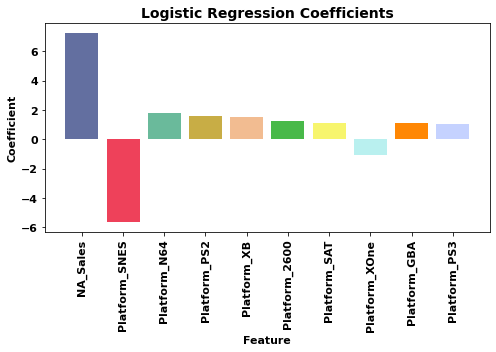

In [44]:
feature_coefficients_sorted_for_plot = feature_coefficients_sorted.head(10)

import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
cmap = matplotlib.cm.get_cmap('cubehelix')
colors = cmap(np.arange(cmap.N))

colors = ['#636FA0','#EE415A','#6ABA9B','#C8AD45','#F2BC91','#48B949',
         '#F7F56D','#B9F0EF','#FF8704','#C5D2FF']

# feature_coefficients_sorted_for_plot.plot.bar(x="Feature", y="Coefficient")
plt.bar(feature_coefficients_sorted_for_plot["Feature"],
        feature_coefficients_sorted_for_plot["Coefficient"],
        color=colors)
plt.xticks(rotation=90, size=11, weight="bold")
plt.yticks(size=11, weight="bold")
plt.title("Logistic Regression Coefficients", size=14, weight="bold")
plt.ylabel("Coefficient", size=11, weight="bold")
plt.xlabel("Feature", size=11, weight="bold")
fig = plt.gcf()
fig.set_size_inches([7,5])
plt.tight_layout()
# plt.savefig('LR_Coefficients_no_bkgnd.png', transparent=True)
plt.show()

Investigate LR Probabilities

In [45]:
probs_test = classifier.predict_proba(X_test)
probs_test

array([[0.792851  , 0.207149  ],
       [0.81512838, 0.18487162],
       [0.74400336, 0.25599664],
       ...,
       [0.66693829, 0.33306171],
       [0.91818832, 0.08181168],
       [0.94935434, 0.05064566]])

In [46]:
len(probs_test)

2450

In [47]:
probs_0 = classifier.predict_proba(X_test)[:,0]
probs_0

array([0.792851  , 0.81512838, 0.74400336, ..., 0.66693829, 0.91818832,
       0.94935434])

In [48]:
probs_1 = classifier.predict_proba(X_test)[:,1]
probs_1

array([0.207149  , 0.18487162, 0.25599664, ..., 0.33306171, 0.08181168,
       0.05064566])

In [49]:
# Create dataframe with predictions and probabilities
pred_df = pd.DataFrame({
    "Validation":y_test,
    "Prediction":y_pred,
    "0_Probability":probs_0,
    "1_Probability":probs_1
})
pred_df

,Validation,Prediction,0_Probability,1_Probability
9071,0.0,0.0,0.792851,0.207149
5494,0.0,0.0,0.815128,0.184872
5330,0.0,0.0,0.744003,0.255997
710,1.0,1.0,0.377828,0.622172
4864,0.0,0.0,0.968758,0.031242
...,...,...,...,...
5588,0.0,0.0,0.882471,0.117529
7994,0.0,0.0,0.902117,0.097883
5825,0.0,0.0,0.666938,0.333062
324,0.0,0.0,0.918188,0.081812


In [50]:
# Create dataframe for 0 class, then create histograms to display probabilities
probs_0_df = pred_df.loc[pred_df["Prediction"] == 0]
probs_0_df.head()

,Validation,Prediction,0_Probability,1_Probability
9071,0.0,0.0,0.792851,0.207149
5494,0.0,0.0,0.815128,0.184872
5330,0.0,0.0,0.744003,0.255997
4864,0.0,0.0,0.968758,0.031242
790,0.0,0.0,0.753356,0.246644


In [51]:
# Create dataframe for 1 class, then create histograms to display probabilities
probs_1_df = pred_df.loc[pred_df["Prediction"] == 1]
probs_1_df.head(10)

,Validation,Prediction,0_Probability,1_Probability
710,1.0,1.0,3.778276e-01,0.622172
2940,1.0,1.0,2.718929e-01,0.728107
4849,1.0,1.0,3.323569e-03,0.996676
5998,1.0,1.0,3.860878e-08,1.000000
3225,0.0,1.0,4.948798e-01,0.505120
5710,1.0,1.0,4.725261e-01,0.527474
8432,1.0,1.0,7.097421e-04,0.999290
8663,0.0,1.0,3.786633e-01,0.621337
281,1.0,1.0,7.804769e-02,0.921952
1702,1.0,1.0,3.967598e-02,0.960324


Create plots for probabilities

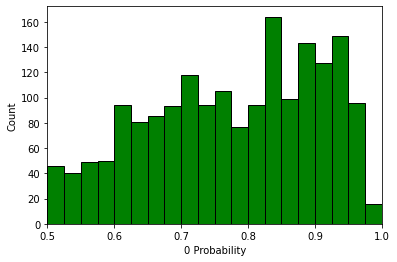

In [52]:
plt.hist(probs_0_df["0_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("0 Probability")
plt.ylabel("Count")
# plt.savefig('LR_0_probability_hist.png')
plt.show()

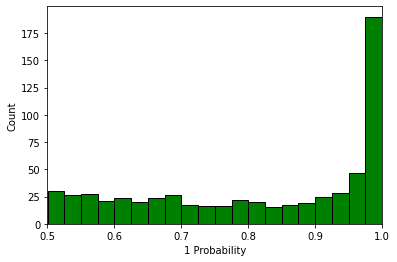

In [53]:
plt.hist(probs_1_df["1_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("1 Probability")
plt.ylabel("Count")
# plt.savefig('LR_1_probability_hist.png')
plt.show()

Combine Prediction Data for Plotting

In [54]:
# Create copy of X_test df
test_combined_df = X_test.copy()
test_combined_df.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
9071,0.03,0.00,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5494,0.14,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5330,0.00,0.19,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
710,0.22,0.03,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4864,0.00,0.04,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [55]:
# Add predictions
test_combined_df["Y_pred"] = y_pred
test_combined_df.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Y_pred
9071,0.03,0.00,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
5494,0.14,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
5330,0.00,0.19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
710,0.22,0.03,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1.0
4864,0.00,0.04,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0


In [56]:
# Create dataframe for 0 predictions
test_combined_pred_0 = test_combined_df.loc[test_combined_df["Y_pred"] == 0]
test_combined_pred_0.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Y_pred
9071,0.03,0.00,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
5494,0.14,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
5330,0.00,0.19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4864,0.00,0.04,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
790,0.00,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [57]:
# Create dataframe for 1 predictions
test_combined_pred_1 = test_combined_df.loc[test_combined_df["Y_pred"] == 1]
test_combined_pred_1.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Y_pred
710,0.22,0.03,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1.0
2940,0.31,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4849,0.94,0.00,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1.0
5998,2.58,0.66,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
3225,0.05,0.01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1.0


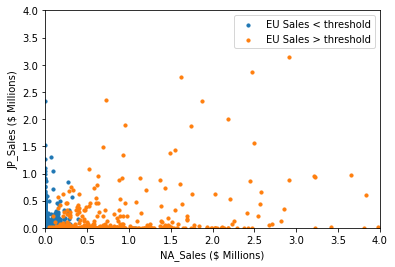

In [58]:
# Create scatter plot for NA_Sales and JP_Sales
plt.scatter(test_combined_pred_0["NA_Sales"], test_combined_pred_0["JP_Sales"], s=10, label='EU Sales < threshold')
plt.scatter(test_combined_pred_1["NA_Sales"], test_combined_pred_1["JP_Sales"], s=10, label='EU Sales > threshold')
plt.legend()
plt.xlim(left=0, right=4)
plt.ylim(bottom=0, top=4)
plt.xlabel("NA_Sales ($ Millions)")
plt.ylabel("JP_Sales ($ Millions)")
# plt.savefig('LR_NA_Sales_vs_JP_Sales.png')
plt.show()

Generate Regression Line and Predictions Plot

In [59]:
# Combine X_test and pred_df
LR_summary = pd.concat([test_combined_df, pred_df], axis=1)
LR_summary.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Y_pred,Validation,Prediction,0_Probability,1_Probability
9071,0.03,0.00,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0.0,0.0,0.0,0.792851,0.207149
5494,0.14,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.0,0.0,0.0,0.815128,0.184872
5330,0.00,0.19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.744003,0.255997
710,0.22,0.03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0,1.0,1.0,0.377828,0.622172
4864,0.00,0.04,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0.0,0.0,0.0,0.968758,0.031242


In [60]:
# Reorganize columns
LR_summary_cols = LR_summary.columns[:2].tolist() + LR_summary.columns[42:].tolist() + LR_summary.columns[2:42].tolist()

# Create dataframe with reorganized columns
LR_summary = LR_summary[LR_summary_cols]
LR_summary.head()

,NA_Sales,JP_Sales,Genre_Strategy,Y_pred,Validation,Prediction,0_Probability,1_Probability,Platform_2600,Platform_3DO,...,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports
9071,0.03,0.00,1,0.0,0.0,0.0,0.792851,0.207149,0,0,...,0,0,0,0,0,0,0,0,0,0
5494,0.14,0.00,1,0.0,0.0,0.0,0.815128,0.184872,0,0,...,0,0,0,0,0,0,0,0,0,0
5330,0.00,0.19,0,0.0,0.0,0.0,0.744003,0.255997,0,0,...,0,1,0,0,0,0,0,0,0,0
710,0.22,0.03,0,1.0,1.0,1.0,0.377828,0.622172,0,0,...,0,0,1,0,0,0,0,0,0,0
4864,0.00,0.04,0,0.0,0.0,0.0,0.968758,0.031242,0,0,...,0,0,0,0,0,0,1,0,0,0


In [61]:
# Sort data based on 1 probability
LR_summary_sorted = LR_summary.sort_values("1_Probability")
LR_summary_sorted.head()

,NA_Sales,JP_Sales,Genre_Strategy,Y_pred,Validation,Prediction,0_Probability,1_Probability,Platform_2600,Platform_3DO,...,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports
3795,0.07,0.0,0,0.0,0.0,0.0,0.999463,0.000537,0,0,...,0,0,0,0,0,0,0,0,0,0
4243,0.14,0.0,0,0.0,0.0,0.0,0.999109,0.000891,0,0,...,0,0,0,0,0,0,0,0,0,0
4121,0.13,0.0,0,0.0,0.0,0.0,0.999041,0.000959,0,0,...,0,1,0,0,0,0,0,0,0,0
7418,0.15,0.0,0,0.0,0.0,0.0,0.998892,0.001108,0,0,...,0,1,0,0,0,0,0,0,0,0
3707,0.20,0.0,1,0.0,0.0,0.0,0.998355,0.001645,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Add counter for plotting
xx = np.arange(0,len(LR_summary_sorted))
LR_summary_sorted["xx_idx"] = xx
LR_summary_sorted.head()

,NA_Sales,JP_Sales,Genre_Strategy,Y_pred,Validation,Prediction,0_Probability,1_Probability,Platform_2600,Platform_3DO,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,xx_idx
3795,0.07,0.0,0,0.0,0.0,0.0,0.999463,0.000537,0,0,...,0,0,0,0,0,0,0,0,0,0
4243,0.14,0.0,0,0.0,0.0,0.0,0.999109,0.000891,0,0,...,0,0,0,0,0,0,0,0,0,1
4121,0.13,0.0,0,0.0,0.0,0.0,0.999041,0.000959,0,0,...,1,0,0,0,0,0,0,0,0,2
7418,0.15,0.0,0,0.0,0.0,0.0,0.998892,0.001108,0,0,...,1,0,0,0,0,0,0,0,0,3
3707,0.20,0.0,1,0.0,0.0,0.0,0.998355,0.001645,0,0,...,0,0,0,0,0,0,0,0,0,4


In [63]:
# Rearrange columns for LR_summary_sorted
LR_summary_sorted_cols = []
LR_summary_sorted_cols.append(LR_summary_sorted.columns[-1])

for item in LR_summary_sorted.columns[:-1]:
    LR_summary_sorted_cols.append(item)
    
LR_summary_sorted = LR_summary_sorted[LR_summary_sorted_cols]
LR_summary_sorted.head()

,xx_idx,NA_Sales,JP_Sales,Genre_Strategy,Y_pred,Validation,Prediction,0_Probability,1_Probability,Platform_2600,...,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports
3795,0,0.07,0.0,0,0.0,0.0,0.0,0.999463,0.000537,0,...,0,0,0,0,0,0,0,0,0,0
4243,1,0.14,0.0,0,0.0,0.0,0.0,0.999109,0.000891,0,...,0,0,0,0,0,0,0,0,0,0
4121,2,0.13,0.0,0,0.0,0.0,0.0,0.999041,0.000959,0,...,0,1,0,0,0,0,0,0,0,0
7418,3,0.15,0.0,0,0.0,0.0,0.0,0.998892,0.001108,0,...,0,1,0,0,0,0,0,0,0,0
3707,4,0.20,0.0,1,0.0,0.0,0.0,0.998355,0.001645,0,...,0,0,0,0,0,0,0,0,0,0


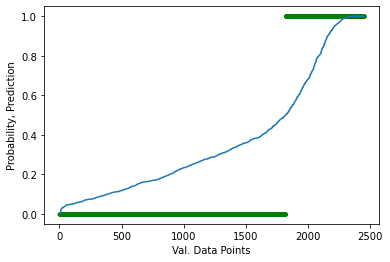

In [64]:
# Create scatter plot with regression line
plt.plot(LR_summary_sorted["xx_idx"], LR_summary_sorted["1_Probability"])
plt.scatter(LR_summary_sorted["xx_idx"], LR_summary_sorted["Prediction"], s=10, color="green")
plt.xlabel("Val. Data Points")
plt.ylabel("Probability, Prediction")
# plt.savefig('LR_predictions_and_regression.png')
plt.show()

## Alternative Resampling Techniques

SMOTE

In [65]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

Counter(y_resampled)

Counter({0.0: 5570, 1.0: 5570})

In [66]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

# Train the model
classifier.fit(X_resampled, y_resampled)

y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)

In [67]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,1689,167
Actual > threshold,126,468


In [68]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      1856
         1.0       0.74      0.79      0.76       594

    accuracy                           0.88      2450
   macro avg       0.83      0.85      0.84      2450
weighted avg       0.88      0.88      0.88      2450



In [69]:
# Investigate probabilities
probs_0 = classifier.predict_proba(X_test)[:,0]
probs_1 = classifier.predict_proba(X_test)[:,1]

# Create dataframe with predictions and probabilities
pred_df = pd.DataFrame({
    "Validation":y_test,
    "Prediction":y_pred,
    "0_Probability":probs_0,
    "1_Probability":probs_1
})

# Create dataframe for 0 class, then create histograms to display probabilities
probs_0_df = pred_df.loc[pred_df["Prediction"] == 0]

# Create dataframe for 1 class, then create histograms to display probabilities
probs_1_df = pred_df.loc[pred_df["Prediction"] == 1]

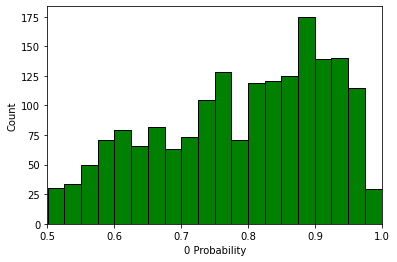

In [70]:
plt.hist(probs_0_df["0_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("0 Probability")
plt.ylabel("Count")
# plt.savefig("LR_0_prob_SMOTE.png")
plt.show()

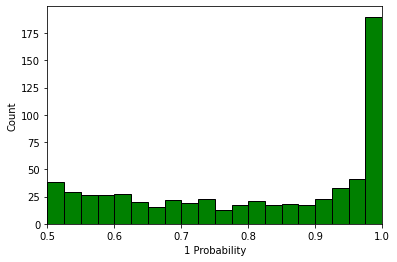

In [71]:
plt.hist(probs_1_df["1_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("1 Probability")
plt.ylabel("Count")
# plt.savefig("LR_1_prob_SMOTE.png")
plt.show()

Random Undersampling

In [72]:
# Undersample the data using `RandomUnderSampler`
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0.0: 1780, 1.0: 1780})

In [73]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

# Train the model
classifier.fit(X_resampled, y_resampled)

y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)

In [74]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,1684,172
Actual > threshold,127,467


In [75]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      1856
         1.0       0.73      0.79      0.76       594

    accuracy                           0.88      2450
   macro avg       0.83      0.85      0.84      2450
weighted avg       0.88      0.88      0.88      2450



In [76]:
# Investigate probabilities
probs_0 = classifier.predict_proba(X_test)[:,0]
probs_1 = classifier.predict_proba(X_test)[:,1]

# Create dataframe with predictions and probabilities
pred_df = pd.DataFrame({
    "Validation":y_test,
    "Prediction":y_pred,
    "0_Probability":probs_0,
    "1_Probability":probs_1
})

# Create dataframe for 0 class, then create histograms to display probabilities
probs_0_df = pred_df.loc[pred_df["Prediction"] == 0]

# Create dataframe for 1 class, then create histograms to display probabilities
probs_1_df = pred_df.loc[pred_df["Prediction"] == 1]

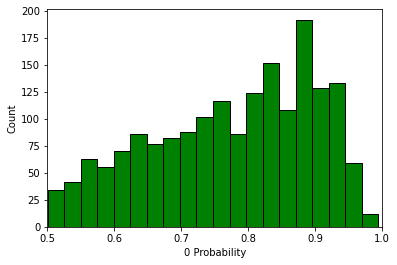

In [77]:
plt.hist(probs_0_df["0_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("0 Probability")
plt.ylabel("Count")
# plt.savefig("LR_0_prob_RUS.png")
plt.show()

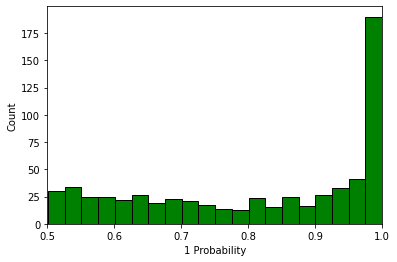

In [78]:
plt.hist(probs_1_df["1_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("1 Probability")
plt.ylabel("Count")
# plt.savefig("LR_1_prob_RUS.png")
plt.show()

Cluster Centroid

In [79]:
# Fit the data using `ClusterCentroids` and check the count of each class
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0.0: 1780, 1.0: 1780})

In [80]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

# Train the model
classifier.fit(X_resampled, y_resampled)

y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)

In [81]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,1500,356
Actual > threshold,115,479


In [82]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.93      0.81      0.86      1856
         1.0       0.57      0.81      0.67       594

    accuracy                           0.81      2450
   macro avg       0.75      0.81      0.77      2450
weighted avg       0.84      0.81      0.82      2450



In [83]:
# Investigate probabilities
probs_0 = classifier.predict_proba(X_test)[:,0]
probs_1 = classifier.predict_proba(X_test)[:,1]

# Create dataframe with predictions and probabilities
pred_df = pd.DataFrame({
    "Validation":y_test,
    "Prediction":y_pred,
    "0_Probability":probs_0,
    "1_Probability":probs_1
})

# Create dataframe for 0 class, then create histograms to display probabilities
probs_0_df = pred_df.loc[pred_df["Prediction"] == 0]

# Create dataframe for 1 class, then create histograms to display probabilities
probs_1_df = pred_df.loc[pred_df["Prediction"] == 1]

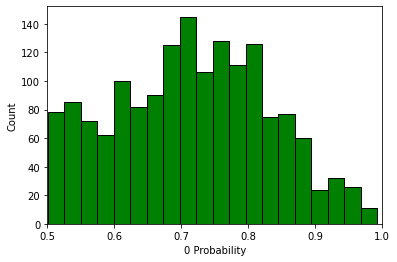

In [84]:
plt.hist(probs_0_df["0_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("0 Probability")
plt.ylabel("Count")
# plt.savefig("LR_0_prob_CC.png")
plt.show()

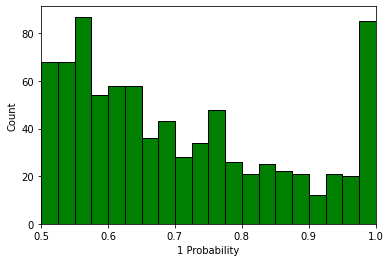

In [85]:
plt.hist(probs_1_df["1_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("1 Probability")
plt.ylabel("Count")
# plt.savefig("LR_1_prob_CC.png")
plt.show()

Combination Sampling

In [86]:
# Use the SMOTEENN technique to perform combination sampling on the data
# Count the resampled classes
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0.0: 4264, 1.0: 4119})

In [87]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

# Train the model
classifier.fit(X_resampled, y_resampled)

y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)

In [88]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,1642,214
Actual > threshold,112,482


In [89]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      1856
         1.0       0.69      0.81      0.75       594

    accuracy                           0.87      2450
   macro avg       0.81      0.85      0.83      2450
weighted avg       0.88      0.87      0.87      2450



In [90]:
# Investigate probabilities
probs_0 = classifier.predict_proba(X_test)[:,0]
probs_1 = classifier.predict_proba(X_test)[:,1]

# Create dataframe with predictions and probabilities
pred_df = pd.DataFrame({
    "Validation":y_test,
    "Prediction":y_pred,
    "0_Probability":probs_0,
    "1_Probability":probs_1
})

# Create dataframe for 0 class, then create histograms to display probabilities
probs_0_df = pred_df.loc[pred_df["Prediction"] == 0]

# Create dataframe for 1 class, then create histograms to display probabilities
probs_1_df = pred_df.loc[pred_df["Prediction"] == 1]

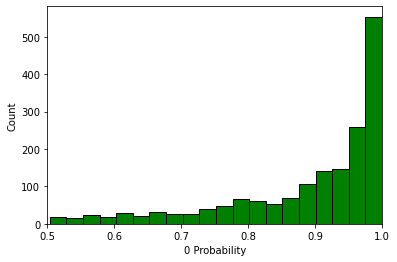

In [91]:
plt.hist(probs_0_df["0_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("0 Probability")
plt.ylabel("Count")
# plt.savefig("LR_0_prob_SMOTEENN.png")
plt.show()

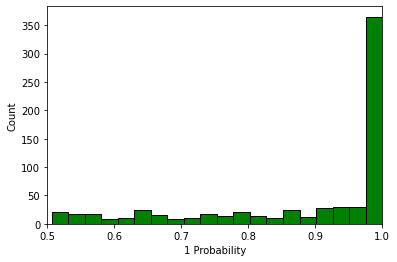

In [92]:
plt.hist(probs_1_df["1_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("1 Probability")
plt.ylabel("Count")
# plt.savefig("LR_1_prob_SMOTEENN.png")
plt.show()

No Resampling

In [93]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

# Train the model
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)

In [94]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,1797,59
Actual > threshold,298,296


In [95]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      1856
         1.0       0.83      0.50      0.62       594

    accuracy                           0.85      2450
   macro avg       0.85      0.73      0.77      2450
weighted avg       0.85      0.85      0.84      2450



In [96]:
# Investigate probabilities
probs_0 = classifier.predict_proba(X_test)[:,0]
probs_1 = classifier.predict_proba(X_test)[:,1]

# Create dataframe with predictions and probabilities
pred_df = pd.DataFrame({
    "Validation":y_test,
    "Prediction":y_pred,
    "0_Probability":probs_0,
    "1_Probability":probs_1
})

# Create dataframe for 0 class, then create histograms to display probabilities
probs_0_df = pred_df.loc[pred_df["Prediction"] == 0]

# Create dataframe for 1 class, then create histograms to display probabilities
probs_1_df = pred_df.loc[pred_df["Prediction"] == 1]

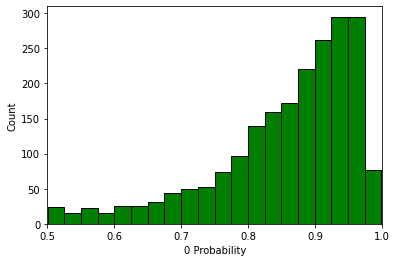

In [97]:
plt.hist(probs_0_df["0_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("0 Probability")
plt.ylabel("Count")
# plt.savefig("LR_0_prob_no_resample.png")
plt.show()

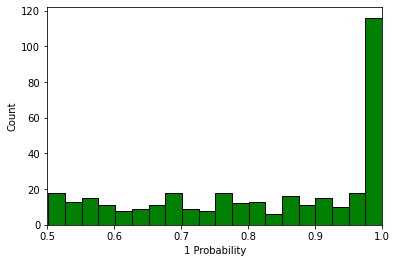

In [98]:
plt.hist(probs_1_df["1_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("1 Probability")
plt.ylabel("Count")
# plt.savefig("LR_1_prob_no_resample.png")
plt.show()